In [1]:
from utils import *
print_version()
cfg = load_config('default')
random_seed = cfg['random_seed']
tf.random.set_seed(cfg['tf_seed'])
np.random.seed(cfg['np_seed'])
data_x, data_y = load_credit_card_dataset()
scaled_x = convert_standard_scale(data_x)

test_split_clm = load_config("supervised.test_split")
x_train, x_test, y_train, y_test = train_test_split(scaled_x, data_y, stratify=data_y, **test_split_clm)

python:      3.10.11 (text: 3.6)
sklearn:     1.2.2
tensorflow:  2.13.0-rc0 (text: 1.14)
keras:       2.13.1rc0
numpy:       1.24.3
pandas:      1.5.3


In [2]:
# Number of negative and positive examples
np.sum(y_train==0),np.sum(y_train==1)

(190490, 330)

In [3]:
# 訓練セットの90％をDrop
drop_idx = y_train[y_train==1].sample(frac=0.90, random_state=random_seed).index
x_train.drop(labels=drop_idx, inplace=True)
y_train.drop(labels=drop_idx, inplace=True)

In [4]:
# Shape of data
print([each.shape for each in (x_train, x_test, y_train, y_test)])

[(190523, 29), (93987, 29), (190523,), (93987,)]


In [5]:
# Check the number of fruadulant cases left after dropping 90%
np.sum(y_train==0),np.sum(y_train==1)

(190490, 33)

In [6]:
# 9.2 教師ありモデル

# k分割交差検証
k_fold_prm = load_config('supervised.k_fold')
#　k-foldは，`StratifiedKFold`　を使用しているため，y_trainのラベル分布が近くなるように分割する．
k_fold = StratifiedKFold(**k_fold_prm)
predictions_based_on_k_folds = pd.DataFrame(
    data=[], index=y_train.index, columns=['prediction']
)
# 学習
training_scores = [] # 学習率
validation_scores = [] # 検証スコア

# x_trainの値の分布を考慮せずに分割して欲しいため，0埋めした配列を`split()`の引数にいれ，そのランダムなインデックスのリストを取得する．
for train_idx, validation_idx in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    x_train_fold, x_validation_fold = x_train.iloc[train_idx, :], x_train.iloc[validation_idx, :] # 2次元配列
    y_train_fold, y_validation_fold = y_train.iloc[train_idx], y_train.iloc[validation_idx] # １次元配列

    lgb_train = lgb.Dataset(x_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(x_validation_fold, y_validation_fold, reference=lgb_train)
    lgb_params = load_config('supervised.lgb')
    gbm = lgb.train(lgb_params, lgb_train,
                         num_boost_round=2000,
                         valid_sets=lgb_eval,
                         callbacks=[lgb.early_stopping(200)]
                         )

    y_train_predict = gbm.predict(x_train_fold, num_iteration=gbm.best_iteration)
    training_score = log_loss(y_train_fold, y_train_predict)

    y_validation_predict = gbm.predict(x_validation_fold, num_iteration=gbm.best_iteration)
    predictions_based_on_k_folds.loc[x_validation_fold.index, 'prediction'] = y_validation_predict
    validation_score = log_loss(y_validation_fold, y_validation_predict)


    print(f"training log loss:  {training_score}")
    print(f"validation log loss: {validation_score}")
    training_scores.append(training_score)
    validation_scores.append(validation_score)

/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.00328814
training log loss:  0.002931231218128015
validation log loss: 0.0032881388005420696


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.002832
training log loss:  0.002783470999943539
validation log loss: 0.0028320009917654106


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00262917
training log loss:  6.042001725578315e-05
validation log loss: 0.002629169106825082


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00220288
training log loss:  7.958947525207722e-05
validation log loss: 0.0022028817657859107


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00269113
training log loss:  0.00012305377324847534
validation log loss: 0.0026911288799465506


In [7]:
log_loss_light_gbm_gradient_boosting = log_loss(y_train, predictions_based_on_k_folds.loc[:, 'prediction'])
print(f'Light GBM Gradient Boosting Log loss: {log_loss_light_gbm_gradient_boosting}')

Light GBM Gradient Boosting Log loss: 0.002728666865661552


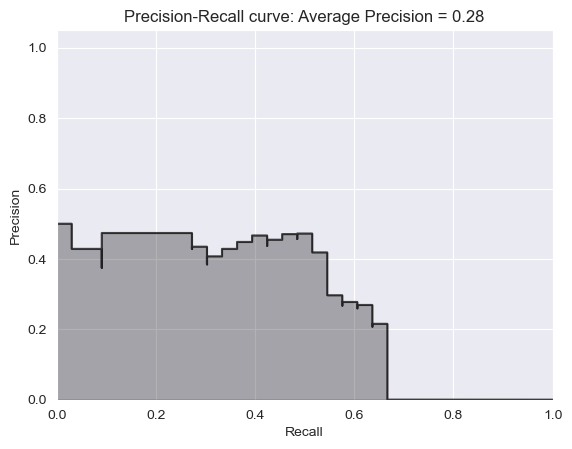

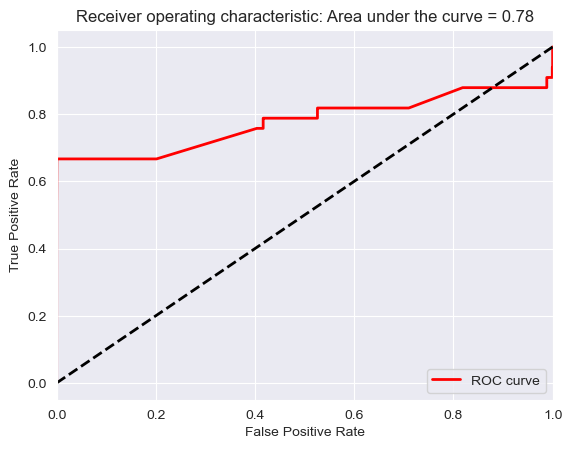

average_precision: 0.28069976178310263


In [8]:
_, average_precision = plot_results(y_train, predictions_based_on_k_folds.loc[:,'prediction'], True)
print(f"average_precision: {average_precision}")

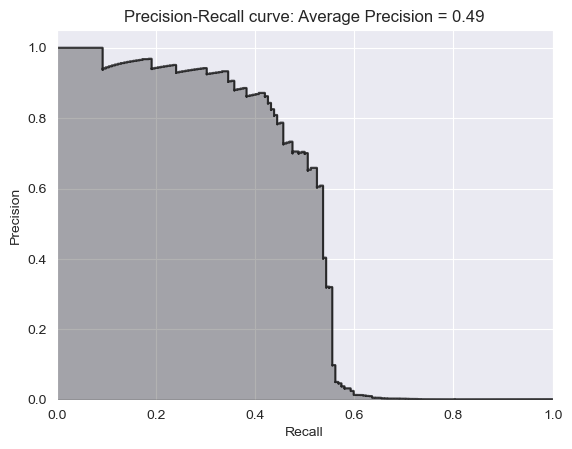

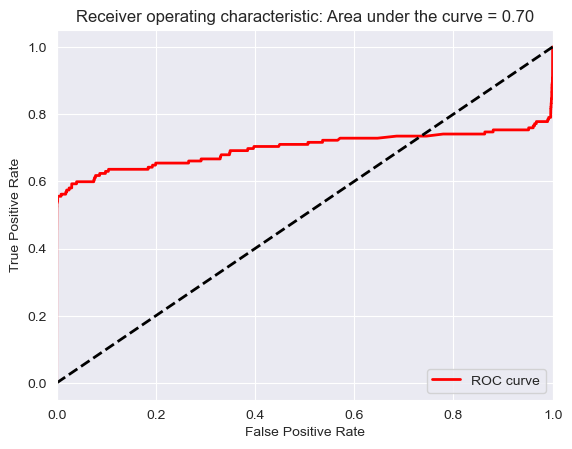

In [9]:
# Evaluate on Test Set
predictions = pd.Series(data=gbm.predict(x_test,
                                         num_iteration=gbm.best_iteration), index=x_test.index)
preds, average_precision = plot_results(y_test, predictions, True)

In [10]:
# Calculate precision at 75% recall
preds, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.0014


In [11]:
# 9.3 教師なしモデル
over_sample_multiplier: int = load_config('unsupervised.over_sample_multiplier')
x_train_oversampled = x_train.copy()
y_train_oversampled = y_train.copy()
x_train_oversampled = x_train_oversampled.append([x_train_oversampled[y_train==1]] * over_sample_multiplier, ignore_index=False)
y_train_oversampled = y_train_oversampled.append([y_train_oversampled[y_train==1]] * over_sample_multiplier, ignore_index=False)
# View shape
x_train_oversampled.shape, y_train_oversampled.shape

/var/folders/04/0tzys4b55532g9l6wv_dj4f40000gn/T/ipykernel_71478/2094682171.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  x_train_oversampled = x_train_oversampled.append([x_train_oversampled[y_train==1]] * over_sample_multiplier, ignore_index=False)
/var/folders/04/0tzys4b55532g9l6wv_dj4f40000gn/T/ipykernel_71478/2094682171.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_train_oversampled = y_train_oversampled.append([y_train_oversampled[y_train==1]] * over_sample_multiplier, ignore_index=False)


((193823, 29), (193823,))

In [12]:
model = keras.Sequential([
    Dense(units=40, activation='linear', activity_regularizer=regularizers.l1(10e-5), input_dim=29, name='hidden_layer'),
    Dropout(0.02),
    Dense(units=29, activation='linear')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (Dense)        (None, 40)                1200      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 29)                1189      
                                                                 
Total params: 2389 (9.33 KB)
Trainable params: 2389 (9.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
compile_prm = load_config('unsupervised.compile')
model.compile(**compile_prm)
fit_prm = load_config('unsupervised.fit')
history = model.fit(x=x_train_oversampled, y=x_train_oversampled, **fit_prm)

Epoch 1/5
4846/4846 [==============================] - 2s 468us/step - loss: 0.0848 - accuracy: 0.8581 - val_loss: 0.0070 - val_accuracy: 0.9840
Epoch 2/5
4846/4846 [==============================] - 2s 457us/step - loss: 0.0178 - accuracy: 0.9263 - val_loss: 0.0333 - val_accuracy: 0.9785
Epoch 3/5
4846/4846 [==============================] - 2s 462us/step - loss: 0.0172 - accuracy: 0.9261 - val_loss: 0.0382 - val_accuracy: 0.9819
Epoch 4/5
4846/4846 [==============================] - 2s 495us/step - loss: 0.0169 - accuracy: 0.9270 - val_loss: 0.1631 - val_accuracy: 0.9461
Epoch 5/5
4846/4846 [==============================] - 2s 467us/step - loss: 0.0170 - accuracy: 0.9267 - val_loss: 0.0442 - val_accuracy: 0.9723


5954/5954 [==============================] - 1s 235us/step
142087    0.004281
165168    0.003379
235908    0.010706
148255    0.002508
145672    0.007348
            ...   
30023     0.005547
195475    0.075105
48687     0.023995
159608    0.003607
197673    0.029244
Length: 190523, dtype: float64


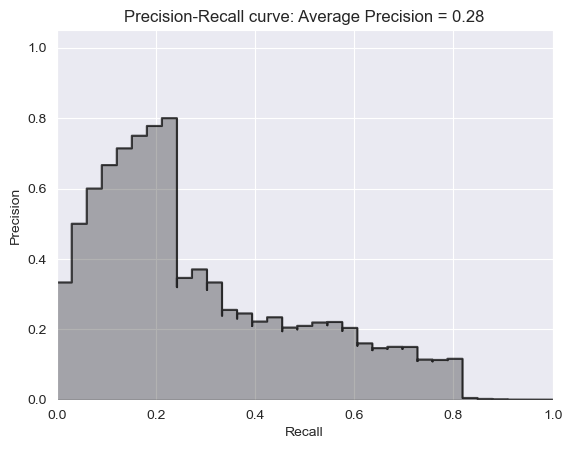

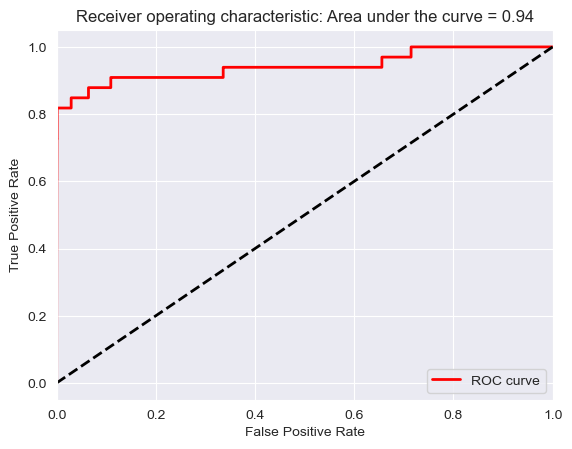

In [14]:
predictions_train = model.predict(x_train, verbose=1)
annomaly_scores_ae_train = anomaly_scores(x_train, predictions_train)
preds, average_precision = plot_results(y_train, annomaly_scores_ae_train, True)

2938/2938 [==============================] - 1s 325us/step
67353     0.004599
67626     0.021602
169699    0.006266
217315    0.025586
111420    0.008984
            ...   
70762     0.003143
69843     0.734960
191806    0.011458
259722    0.004779
36616     0.013541
Length: 93987, dtype: float64


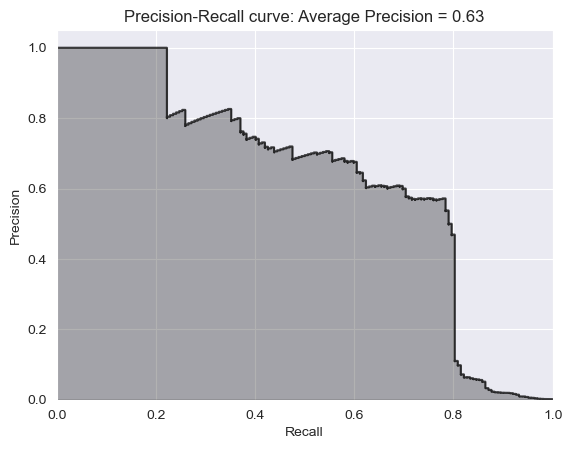

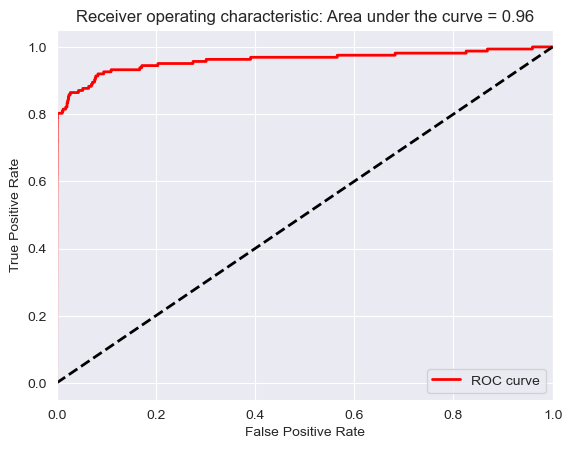

In [15]:
# Evaluate on test set
predictions = model.predict(x_test, verbose=1)
anomaly_scores_ae = anomaly_scores(x_test, predictions)
preds, average_precision = plot_results(y_test, anomaly_scores_ae, True)

In [16]:
# Calculate precision at 75% recall
preds, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'Precision at 75% recall {round(precision,4)}')

Precision at 75% recall 0.5721


In [17]:
# 9.4 半教師ありモデル

# 入力が29，出力が40
intermediate_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer("hidden_layer").output)
intermediate_output_train = intermediate_model.predict(x_train)
intermediate_output_test = intermediate_model.predict(x_test)

intermediate_output_train_df = pd.DataFrame(data=intermediate_output_train, index=x_train.index)
intermediate_output_test_df = pd.DataFrame(data=intermediate_output_test, index=x_test.index)

# with_ae は元のデータセットの２９個の特徴量と，オートエンコーダ由来の４０個の表現を併せ持つ
x_train_with_ae = x_train.merge(intermediate_output_train_df, left_index=True, right_index=True)
x_test_with_ae = x_test.merge(intermediate_output_test_df, left_index=True, right_index=True)
y_train_with_ae = y_train.copy()
x_train_with_ae.shape, y_train_with_ae.shape, x_train_with_ae.columns

2938/2938 [==============================] - 1s 223us/step


((190523, 69),
 (190523,),
 Index([ '0_x',  '1_x',  '2_x',  '3_x',  '4_x',  '5_x',  '6_x',  '7_x',  '8_x',
         '9_x', '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x',
        '18_x', '19_x', '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x',
        '27_x', '28_x',  '0_y',  '1_y',  '2_y',  '3_y',  '4_y',  '5_y',  '6_y',
         '7_y',  '8_y',  '9_y', '10_y', '11_y', '12_y', '13_y', '14_y', '15_y',
        '16_y', '17_y', '18_y', '19_y', '20_y', '21_y', '22_y', '23_y', '24_y',
        '25_y', '26_y', '27_y', '28_y',     29,     30,     31,     32,     33,
            34,     35,     36,     37,     38,     39],
       dtype='object'))

In [18]:
# 学習
training_scores = [] # 学習率
validation_scores = [] # 検証スコア

predictions_based_on_k_folds = pd.DataFrame(
    data=[], index=y_train_with_ae.index, columns=['prediction']
)
for train_idx, validation_idx in k_fold.split(np.zeros(len(x_train_with_ae)), y_train_with_ae.ravel()):
    x_train_fold, x_validation_fold = x_train_with_ae.iloc[train_idx, :], x_train_with_ae.iloc[validation_idx, :] # 2次元配列
    y_train_fold, y_validation_fold = y_train_with_ae.iloc[train_idx], y_train_with_ae.iloc[validation_idx] # １次元配列

    lgb_train = lgb.Dataset(x_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(x_validation_fold, y_validation_fold, reference=lgb_train)
    lgb_params = load_config('supervised.lgb')
    gbm = lgb.train(lgb_params, lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    callbacks=[lgb.early_stopping(200)]
                    )

    y_train_predict = gbm.predict(x_train_fold, num_iteration=gbm.best_iteration)
    training_score = log_loss(y_train_fold, y_train_predict)

    y_validation_predict = gbm.predict(x_validation_fold, num_iteration=gbm.best_iteration)
    predictions_based_on_k_folds.loc[x_validation_fold.index, 'prediction'] = y_validation_predict
    validation_score = log_loss(y_validation_fold, y_validation_predict)


    print(f"training log loss:  {training_score}")
    print(f"validation log loss: {validation_score}")
    training_scores.append(training_score)
    validation_scores.append(validation_score)

/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.00101474
training log loss:  0.0024136751513859638
validation log loss: 0.0010147413406561435


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.000425386
training log loss:  0.00016356893438789906
validation log loss: 0.00042538600100307613


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.00304478
training log loss:  4.584231187685216e-05
validation log loss: 0.003044782466663295


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's binary_logloss: 0.00334475
training log loss:  0.002887320039374941
validation log loss: 0.00334474969725719


/Users/satun/anaconda3/envs/ml/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[180]	valid_0's binary_logloss: 0.00120802
training log loss:  7.18990028713544e-05
validation log loss: 0.0012080160311468515


In [19]:
# Print results
log_loss_light_gbm_gradient_boosting = log_loss(y_train_with_ae, predictions_based_on_k_folds.loc[:,'prediction'])
print(f'LightGBM Gradient Boosting Log Loss: {round(log_loss_light_gbm_gradient_boosting, 4)}')

LightGBM Gradient Boosting Log Loss: 0.0018


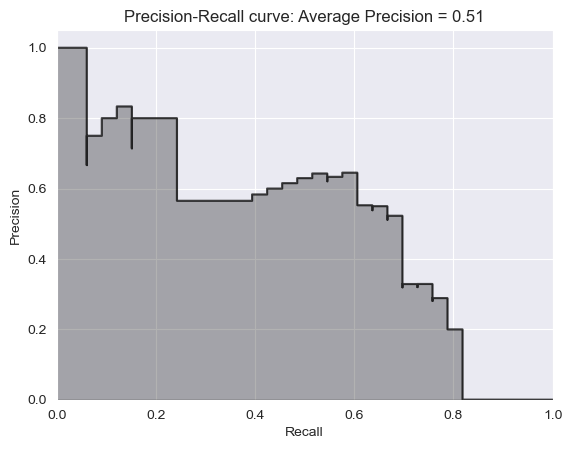

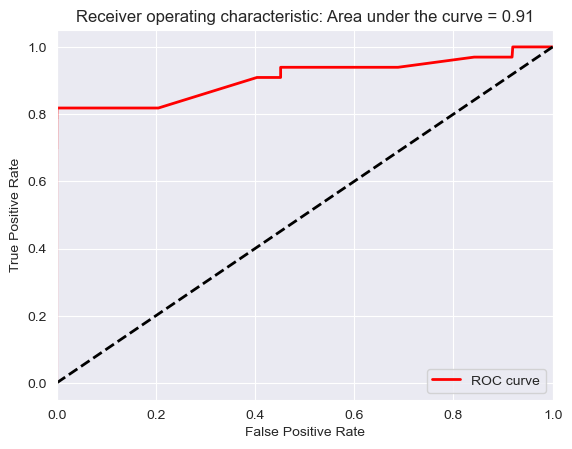

In [20]:
preds, average_precision = plot_results(y_train_with_ae, predictions_based_on_k_folds.loc[:,'prediction'], True)

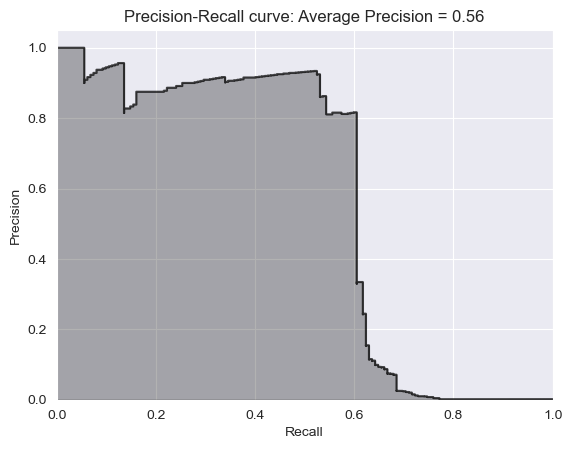

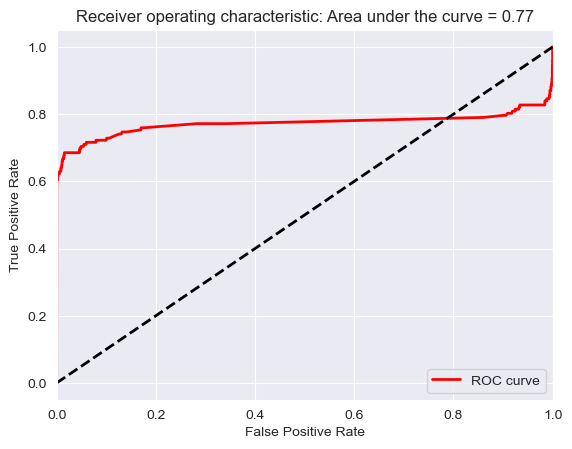

In [21]:
# Evaluate results on test set
predictions = pd.Series(data=gbm.predict(x_test_with_ae, num_iteration=gbm.best_iteration),index=x_test_with_ae.index)
preds, average_precision = plot_results(y_test, predictions, True)

In [22]:
# Calculate precision at 75% recall
preds, precision = precision_analysis(preds, "anomaly_score", 0.75)
print(f'{round(precision,4)}')

0.0077


In [23]:
# Analyze most important features
featuresImportance = pd.DataFrame(data=list(gbm.feature_importance()), index=x_train_with_ae.columns,columns=['featImportance'])
featuresImportance = featuresImportance/featuresImportance.sum()
featuresImportance.sort_values(by='featImportance', ascending=False,inplace=True)
featuresImportance

,featImportance
17_y,0.103178
6_x,0.066301
8_y,0.065124
10_x,0.054531
21_y,0.052177
...,...
17_x,0.000000
35,0.000000
3_x,0.000000
0_y,0.000000


In [24]:
print([each.shape for each in (x_train, x_test, y_train, y_test)])


[(190523, 29), (93987, 29), (190523,), (93987,)]
